# Organización de Datos (75.06/95.58)
## Primer Cuatrimestre 2021
### Trabajo Práctico N°1
#### Curso 1: Argerich

----

##### Introducción:
En el año 2015 Nepal fue afectado por el terremoto Gorkha, un sismo que registró una
magnitud de 7.8 en la escala Richter y tuvo su epicentro en la ciudad de Kathmandu.
Aproximadamente 600,000 estructuras en el centro y pueblos aledaños fueron dañadas o
destruidas. Un análisis posterior al sismo llevado por la Comisión Nacional de
Planeamiento de Nepal comunicó que la pérdida total económica ocasionada por el
terremoto fue de aproximadamente $7 mil millones (USD; NPC, 2015).
El dataset para el presente TP está compuesto de encuestas realizadas por Kathmandu
Living Labs y el Central Bureau of Statistics y contiene información sobre el impacto del
terremoto, estado de viviendas y estadísticas sociodemográficas.
Particularmente el dataset se enfoca en cómo eran las condiciones de una determinada vivienda y cuál fue su grado de daño luego del accidente. 


In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib as mpl
import cycler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pathlib import Path
import pickle
import time
import category_encoders as ce

# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

#seteando la paleta de colores
estilo = "mako"
cmap_cycler = sns.color_palette(estilo, n_colors = 280)
cmap = sns.color_palette(estilo, n_colors = 2000)[:500:-1]


plt.rcParams['axes.grid'] = True
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_cycler[200::-20])
cmap_horizontal = mpl.rcParams['axes.prop_cycle'][::5]

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# lectura de archivos csv
train_values=pd.read_csv('train_values.csv',
                        dtype={
                            'geo_level_1_id':'int8',
                            'geo_level_2_id':'int16',
                            'geo_level_3_id':'int16',
                            'count_floors_pre_eq':'int8',
                            'age':'int16',
                            'area_percentage':'int8',
                            'height_percentage':'int8',
                            'land_surface_condition':'category',                 
                            'foundation_type':'category',                          
                            'roof_type':'category',                                 
                            'ground_floor_type':'category',                        
                            'other_floor_type':'category',                          
                            'position':'category',                                  
                            'plan_configuration':'category',
                            'has_superstructure_adobe_mud':'bool',               
                            'has_superstructure_mud_mortar_stone':'bool',        
                            'has_superstructure_stone_flag':'bool',             
                            'has_superstructure_cement_mortar_stone':'bool',     
                            'has_superstructure_mud_mortar_brick':'bool',        
                            'has_superstructure_cement_mortar_brick':'bool',     
                            'has_superstructure_timber':'bool',                  
                            'has_superstructure_bamboo':'bool',                  
                            'has_superstructure_rc_non_engineered':'bool',       
                            'has_superstructure_rc_engineered':'bool',          
                            'has_superstructure_other':'bool',
                            'legal_ownership_status':'category',
                            'count_families':'int8',
                            'has_secondary_use':'bool',                          
                            'has_secondary_use_agriculture':'bool',             
                            'has_secondary_use_hotel':'bool',                    
                            'has_secondary_use_rental':'bool',                  
                            'has_secondary_use_institution':'bool',             
                            'has_secondary_use_school':'bool',                
                            'has_secondary_use_industry':'bool',              
                            'has_secondary_use_health_post':'bool',         
                            'has_secondary_use_gov_office':'bool',           
                            'has_secondary_use_use_police':'bool',             
                            'has_secondary_use_other':'bool'                   
                        })
train_labels=pd.read_csv('train_labels.csv',
                        dtype={
                            'building_id':'int64',
                            'damage_grade':'int8'
                        })

### Limpieza de datos
- ¿Hay datos faltantes?
    - ¿Son muchos? Caso contrario podríamos simplemente filtrarlos.
- ¿Todos los datos están con el formato correcto?
    - ¿Es necesario transformar alguna columna a tipo categórico/numérico/date_time?
- ¿Los dataframes son muy grandes?
    - ¿Es necesario algun trabajo previo para minimizar el espacio en memoria?
- ¿Hay datos que no tengan sentido?
    - Cuyos valores sean muy grandes para el contexto
    - Que no sean posibles

#### Reviso valores null en mis dataframes

In [4]:
train_labels.isnull().any()

building_id     False
damage_grade    False
dtype: bool

In [5]:
train_values.isnull().any()

building_id                               False
geo_level_1_id                            False
geo_level_2_id                            False
geo_level_3_id                            False
count_floors_pre_eq                       False
age                                       False
area_percentage                           False
height_percentage                         False
land_surface_condition                    False
foundation_type                           False
roof_type                                 False
ground_floor_type                         False
other_floor_type                          False
position                                  False
plan_configuration                        False
has_superstructure_adobe_mud              False
has_superstructure_mud_mortar_stone       False
has_superstructure_stone_flag             False
has_superstructure_cement_mortar_stone    False
has_superstructure_mud_mortar_brick       False
has_superstructure_cement_mortar_brick  

Podemos ver que, por suerte, **ninguno de los dataframes contienen valores NaN.**  
Esto quiere decir que no será necesario ningún tipo de filtro en los datasets a causa de valores faltantes.

#### Chequeando formato de los datos

damage_grade originalmente era int64

In [6]:
train_labels.dtypes

building_id     int64
damage_grade     int8
dtype: object

Muchos valores categóricos eran objects y muchos valores booleanos eran int64, cambiamos sus tipos para optimizar.

In [7]:
train_values.dtypes

building_id                                  int64
geo_level_1_id                                int8
geo_level_2_id                               int16
geo_level_3_id                               int16
count_floors_pre_eq                           int8
age                                          int16
area_percentage                               int8
height_percentage                             int8
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                  bool
has_superstructure_mud_mortar_stone           bool
has_superstructure_stone_flag                 bool
has_superstructure_cement_mortar_stone        bool
has_superstructure_mud_mortar_b

#### Manejo de memoria del dataset
El valor inicialmente (sin castear las columnas al leer el csv) era de 3.97 Mb. Ahora se ve que decreció.

In [8]:
(train_labels.memory_usage()/(2**20)).sum()

2.2368783950805664

El valor inicialmente era de 77.54 Mb podemos observar que ahora la memoria se usa de forma mucho mas óptima.

In [9]:
(train_values.memory_usage()/(2**20)).sum()

12.179516792297363

#### Buscando datos fuera de lo común  
Buscamos si hay valores que no tengan sentido.

##### ¿Hay algún building_id en un dataset que **no** esté en el otro?
Los comparamos y chequeamos si hay algún false, los sumamos.

In [10]:
(train_values['building_id'] != train_labels['building_id']).sum()

0

Observamos que hay correspondencia 1 a 1 entre ambos datasets.
Eso significa que se puede hacer un merge (lo haremos mas adelante)

##### ¿Las variables geo_level_id tiene los valores que dice el enunciado?

In [11]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].max()

geo_level_1_id       30
geo_level_2_id     1427
geo_level_3_id    12567
dtype: int16

Vemos que se corresponde con el enunciado.

In [12]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].min()

geo_level_1_id    0
geo_level_2_id    0
geo_level_3_id    0
dtype: int16

Se corresponde con el enunciado.

##### ¿Hay algún valor de cantidad de familias por hogar que nos llame la atención?
No nos llama la atencion que existan algunas edificaciones con mas de 7 familias, podrían ser por ejemplo bloques de departamentos.
Tambien observamos que hay 20 mil edificaciones sin familias, esto puede ser tranquilamente por ser edificaciones destinadas a otras actividades.

In [13]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

##### ¿Hay valores raros en la cantidad de pisos por edificio?
No vemos que sea inverosimil que un solo edificio tenga 9 u 8 pisos.

In [14]:
train_values['count_floors_pre_eq'].value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count_floors_pre_eq, dtype: int64

##### ¿Area_percentage y Height_percentage están dentro de los valores [0,100]?
Como se observa a continuación, sí.

In [15]:
train_values[['area_percentage','height_percentage']].max()

area_percentage      100
height_percentage     32
dtype: int8

In [16]:
train_values[['area_percentage','height_percentage']].min()

area_percentage      1
height_percentage    2
dtype: int8

##### ¿Hay valores fuera de lo normal para la edad de las edificaciones?

In [17]:
train_values['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
130        9
140        9
180        7
170        6
160        6
175        5
135        5
190        3
145        3
195        2
165        2
185        1
155        1
Name: age, dtype: int64

Si bien podemos observar que hay muchos edificios con antigüedades entre 0 y 200 años (lo cual
consideramos normal) podemos ver que **hay 1390 con antigüedades** de 995 años.  
Lo que nos llama la atención de esto es la brecha entre el valor 200 y 995.
- ¿Por qué no hay valores intermedios? 
- ¿Es posible que una edificación sea tan vieja?  

La forma en la que decidimos interpretar estos datos es que no se tiene una fecha concreta de la construcción de estas viviendas, pero que al ser tan antiguas (más de 200 años) se decidió ingresarlas con edades de 995 años (por eso tantas tienen exactamente esa edad).  
Para el resto de nuestro análisis consideraremos a esas viviendas como simplemente *viviendas muy viejas*

In [18]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False


In [19]:
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


#### Mergeamos los dos dataframes ya que tiene una correspondencia 1 a 1

In [20]:
df=train_values.merge(train_labels)
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3


### Graficamos datos relacionados al area_percentage y height_percentage que usaremos mas adelante.

In [21]:
construcciones_por_area_percentage = df["area_percentage"].value_counts().sort_index()
minimos_casos = construcciones_por_area_percentage.sum()/(construcciones_por_area_percentage.count())

daño_por_area_per = df[["building_id", "area_percentage", "damage_grade"]].pivot_table(index="area_percentage", columns="damage_grade", values="building_id",aggfunc="count").fillna(0)

total_dañados_por_area_per = daño_por_area_per[1]+daño_por_area_per[2]+daño_por_area_per[3]
minimos_casos = minimos_casos
daño_por_area_per_relevantes = daño_por_area_per[total_dañados_por_area_per > minimos_casos]
daño_por_area_per_porcentual_relevantes = daño_por_area_per_relevantes.divide(total_dañados_por_area_per, axis = 0).dropna()
area_per_relevantes = daño_por_area_per_relevantes.index

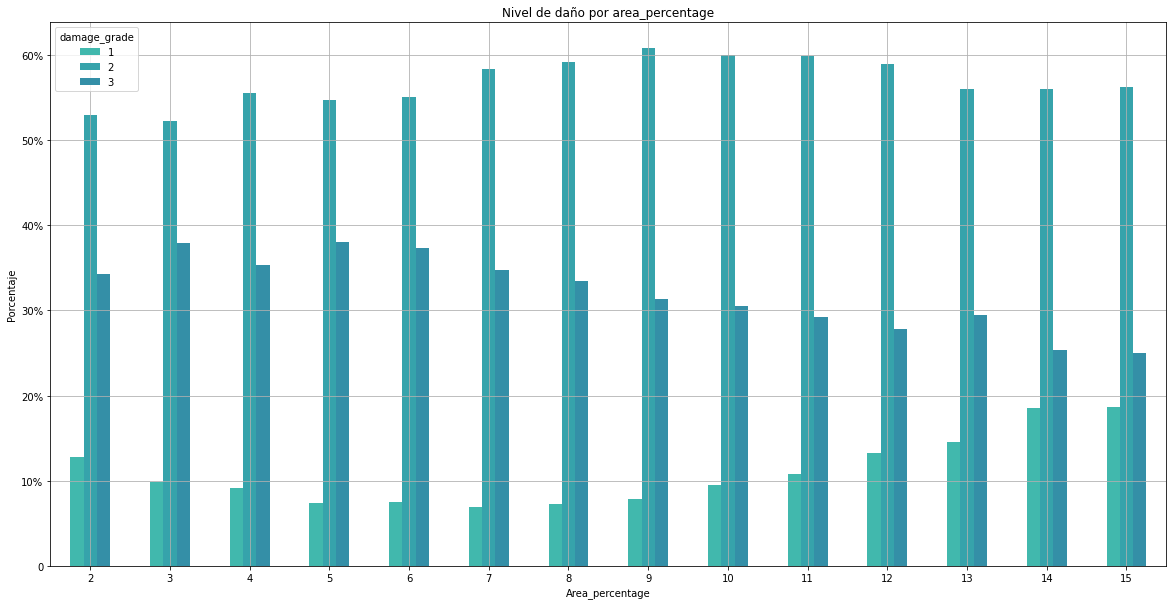

In [22]:
(daño_por_area_per_porcentual_relevantes*100).plot(kind='bar', rot=0, title='Nivel de daño por area_percentage', figsize=(20,10))
plt.ylabel('Porcentaje')
plt.xlabel('Area_percentage')
plt.yticks([0,10,20,30,40,50,60],['0','10%','20%','30%','40%','50%','60%'])
plt.show()


In [23]:
construcciones_por_height_percentage = df["height_percentage"].value_counts().sort_index()
minimos_casos = construcciones_por_height_percentage.sum()/(construcciones_por_height_percentage.count())

daño_por_height_per = df[["building_id", "height_percentage", "damage_grade"]].pivot_table(index="height_percentage", columns="damage_grade", values="building_id",aggfunc="count").fillna(0)

total_dañados_por_height_per = daño_por_height_per[1]+daño_por_height_per[2]+daño_por_height_per[3]
minimos_casos = 0
daño_por_height_per_relevantes = daño_por_height_per[total_dañados_por_height_per > minimos_casos]
daño_por_height_per_porcentual_relevantes = daño_por_height_per_relevantes.divide(total_dañados_por_height_per, axis = 0).dropna()
height_per_relevantes = daño_por_height_per_relevantes.index

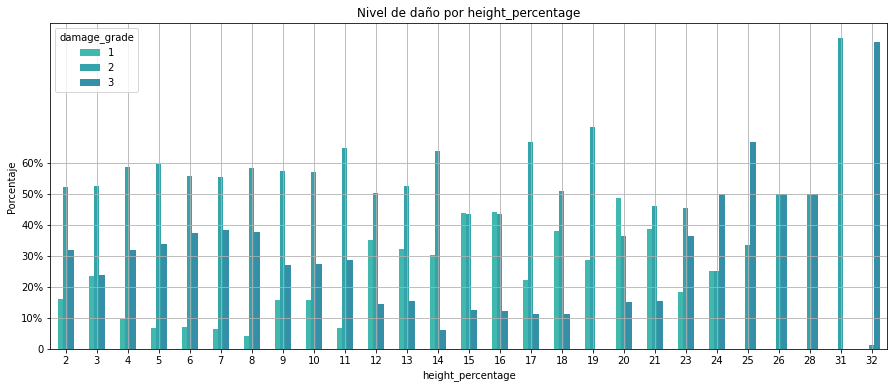

In [24]:
(daño_por_height_per_porcentual_relevantes*100).plot(kind='bar', rot=0, title='Nivel de daño por height_percentage', figsize=(15,6))
plt.ylabel('Porcentaje')
plt.xlabel('height_percentage')
plt.yticks([0,10,20,30,40,50,60],['0','10%','20%','30%','40%','50%','60%'])
plt.show()

# Manipulamos los features categóricos

#### Encodeamos con one-hot encoding los atributos categóricos. 
- No usamos: geo_level 2, ni geo_level3 (porque no escala bien con one-hot encoding ya que son muchas categorías, mas adelante investigamos con otras formas de encodear) Tampoco building_id (pues es unico de cada dato y no sirve para predecir)
- No hace falta estandarizar ya que no cambia el orden de los atributos (que es lo que nos interesa en los arboles de decisión). Por la misma razón no nos importa que haya edificios con una edad de 900 años pues dijimos que los consideramos como "edificios muy viejos" y al hacer el split se mantiene esa propiedad.

In [25]:
one_hotear = {'geo_level_1_id': 'geo1', 'land_surface_condition': 'lsc',
             'roof_type':'roof', 'foundation_type': 'foundation',
             'ground_floor_type':'ground_floor',
             'other_floor_type':'other_floor', 'position':'pos',
             'legal_ownership_status':'ownership',
             'plan_configuration':'plan'}

In [26]:
a_dropear = ['geo_level_2_id', 'geo_level_3_id', 'building_id']

In [27]:
def one_hot(df, feature, prefix):
    y = pd.get_dummies(df[feature], prefix=prefix)
    df = df.drop(feature, axis = 1)
    df = df.join(y)
    return df

In [28]:
def encodear(df, d):
    for key,value in d.items():
        df = one_hot(df, key, value)
    return df

In [29]:
def dropear(df, l):
    for feature in l:
        df = df.drop(feature, axis=1)
    return df

In [30]:
geo_level_2 = df['geo_level_2_id']
geo_level_3 = df['geo_level_3_id']
df = encodear(df, one_hotear)
df = dropear(df, a_dropear)

In [31]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u
0,2,30,6,5,True,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,2,10,8,7,False,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,2,10,5,5,False,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,2,10,6,5,False,True,False,False,False,False,True,True,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,3,30,8,9,True,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [32]:
labels = df['damage_grade']
df = df.drop('damage_grade', axis=1)
df = df.join(labels)

In [33]:
data1 = df
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 97 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   count_floors_pre_eq                     260601 non-null  int8 
 1   age                                     260601 non-null  int16
 2   area_percentage                         260601 non-null  int8 
 3   height_percentage                       260601 non-null  int8 
 4   has_superstructure_adobe_mud            260601 non-null  bool 
 5   has_superstructure_mud_mortar_stone     260601 non-null  bool 
 6   has_superstructure_stone_flag           260601 non-null  bool 
 7   has_superstructure_cement_mortar_stone  260601 non-null  bool 
 8   has_superstructure_mud_mortar_brick     260601 non-null  bool 
 9   has_superstructure_cement_mortar_brick  260601 non-null  bool 
 10  has_superstructure_timber               260601 non-null  bool 
 11  

In [34]:
data1.head()
data1.shape

(260601, 97)

# RANDOM FOREST 
#### Híper parámetros
* n_estimators: cantidad de árboles a construir
* max_depth: máxima profundidad de cada árbol
* min_samples_split: la cantidad mínima de datos requeridos para splitear un nodo interno
* min_samples_leaf: cantidad mínima de datos requeridos para ser una hoja
* max_features: la cantidad de features a considerar cuando se busca el mejor split

Arrancaremos con un modelo simple para probar que funcione todo y hacer el primer submit.

#### Vimos que tenemos un score de 0.67 
Veamos que la importancia de los features.

### Con este primer vistazo parece que la edad es un feature importante (como habiamos analizado en el TP1)

#### Teniamos features que no son muy descriptivos y parecían no aportar mucho a simple vista, veamos si esto es cierto quitando esos features y corriendo el algoritmo de nuevo.

#### El score empeoró.  

Veamos la importancia de los features acá

## Gridsearch con los hiperparámetros más importantes.

### Se entrenó en 57 minutos. Los resultados no fueron buenos.

#### Vemos que el feature mas importante según este modelo es la edad (como habiamos visto en el TP1) y vemos que tambien le da mucho importancia al area_percentage y height_percentage (cosa que no habíamos concluido en nuestro TP1).

#### Tambien vemos que en el resto de features importantes aparecen features ligados a el material con el que están hechas las superestructuras, cosa que hicimos mucho enfásis al hacer el analisis exploratorio de datos. Veremos si podemos generar nuevos features que sean interacciones de estos (ej: que solo este hecho de madera/cemento y no tenga nada de barro)

#### Por ultimo hay que aclarar que se le está dando importancia al geo_level. Asumimos que esto es porque se estan filtrando datos futuros (el geo_level podría indicar donde fue el epicentro del terremoto). En un caso de la vida real este dato no lo podríamos tener en cuenta ya que no podemos saber donde será el epicentro, pero por fines de la competencia los usaremos para predecir y tener un mejor puntaje. Asimismo ahora incluiremos los geo_level2 y geo_level3 para ver si mejoran nuestras predicciones. Usaremos binary encoding para geo_level2 y geo_level3 pero podriamos considerar usar mean encoding (con cuidado de no overfittear, repasar las técnicas)

## Feature Engineering

#### Agrupemos los features y mostremos las interacciones

In [35]:
def agrupar_barro(df):
    barro = df['has_superstructure_adobe_mud'] | df['has_superstructure_mud_mortar_brick']\
            | df['has_superstructure_mud_mortar_stone']
    df = df.drop(['has_superstructure_adobe_mud','has_superstructure_mud_mortar_brick','has_superstructure_mud_mortar_stone'],axis=1)
    df = df.assign(superestructura_barro=barro)
    return df

In [36]:
def agrupar_cemento(df):
    cemento = df['has_superstructure_cement_mortar_brick'] | df['has_superstructure_cement_mortar_stone']
    df = df.drop(['has_superstructure_cement_mortar_brick','has_superstructure_cement_mortar_stone'],axis=1)
    df = df.assign(superestructura_cemento=cemento)
    return df

In [37]:
def agrupar_concreto(df):
    concreto_reforzado = df['has_superstructure_rc_engineered'] | df['has_superstructure_rc_non_engineered']
    df = df.drop(['has_superstructure_rc_engineered','has_superstructure_rc_non_engineered'],axis=1)
    df = df.assign(superestructura_concreto_reforzado=concreto_reforzado)
    return df

In [38]:
def feature_cemento_sin_barro(df):
    cemento_sin_barro = (~df['superestructura_barro']) & df['superestructura_cemento']
    df = df.assign(superestructura_cemento_sin_barro=cemento_sin_barro)
    return df

In [39]:
def feature_concreto_sin_barro(df):
    concreto_sin_barro = (~df['superestructura_barro']) & df['superestructura_concreto_reforzado']
    df = df.assign(superestructura_concreto_sin_barro=concreto_sin_barro)
    return df

In [40]:
def feature_antiguedad_y_materiales(df):
    mas40_sin_rc = (df['age']>=40) & (~df['superestructura_concreto_reforzado'])
    menos40_con_rc_sin_barro = (df['age']<40) & df['superestructura_concreto_sin_barro']
    mas40_sin_cemento = (df['age']>=40) & (~df['superestructura_cemento'])
    menos40_con_cemento_sin_barro = (df['age']<40) & df['superestructura_cemento_sin_barro']
    df = df.assign(mas40_sin_rc=mas40_sin_rc)
    df = df.assign(menos40_con_rc_sin_barro=menos40_con_rc_sin_barro)
    df = df.assign(mas40_sin_cemento=mas40_sin_cemento)
    df = df.assign(menos40_con_cemento_sin_barro=menos40_con_cemento_sin_barro)
    return df

In [41]:
# BINARY ENCODING
encoder = ce.BinaryEncoder(cols=['geo_level_2_id'],return_df=True)
encoder2 = ce.BinaryEncoder(cols=['geo_level_3_id'],return_df=True)

### Genero 4 datasets distintos para ver que combinacion de features me da mejor. Usando el random forest de 200 arboles y max_leaf=20 que hayamos con el gridsearch

In [42]:
data3 = df

In [43]:
data3 = agrupar_barro(data3)
data3 = agrupar_cemento(data3)
data3 = agrupar_concreto(data3)
data3 = feature_cemento_sin_barro(data3)
data3 = feature_concreto_sin_barro(data3)
data3 = data3.drop('damage_grade',axis=1)
data4 = data3
data3 = data3.join(labels)
data3.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_stone_flag,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u,superestructura_barro,superestructura_cemento,superestructura_concreto_reforzado,superestructura_cemento_sin_barro,superestructura_concreto_sin_barro,damage_grade
0,2,30,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,3
1,2,10,8,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,2
2,2,10,5,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,3
3,2,10,6,5,False,True,True,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,2
4,3,30,8,9,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,3


In [44]:
geo2_bin = encoder.fit_transform(geo_level_2)
geo3_bin = encoder2.fit_transform(geo_level_3)

/home/matias/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/matias/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [45]:
data4 = data4.join(geo2_bin)
data4 = data4.join(geo3_bin)
data4 = data4.join(labels)
data4

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_stone_flag,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u,superestructura_barro,superestructura_cemento,superestructura_concreto_reforzado,superestructura_cemento_sin_barro,superestructura_concreto_sin_barro,geo_level_2_id_0,geo_level_2_id_1,geo_level_2_id_2,geo_level_2_id_3,geo_level_2_id_4,geo_level_2_id_5,geo_level_2_id_6,geo_level_2_id_7,geo_level_2_id_8,geo_level_2_id_9,geo_level_2_id_10,geo_level_2_id_11,geo_level_3_id_0,geo_level_3_id_1,geo_level_3_id_2,geo_level_3_id_3,geo_level_3_id_4,geo_level_3_id_5,geo_level_3_id_6,geo_level_3_id_7,geo_level_3_id_8,geo_level_3_id_9,geo_level_3_id_10,geo_level_3_id_11,geo_level_3_id_12,geo_level_3_id_13,geo_level_3_id_14,damage_grade
0,2,30,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
1,2,10,8,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
2,2,10,5,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3
3,2,10,6,5,False,True,True,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2
4,3,30,8,9,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1,55,6,3,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [46]:
data5 = data3
data5 = feature_antiguedad_y_materiales(data5)
data5 = data5.drop('damage_grade',axis=1)
data5 = data5.join(labels)
data5

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_stone_flag,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u,superestructura_barro,superestructura_cemento,superestructura_concreto_reforzado,superestructura_cemento_sin_barro,superestructura_concreto_sin_barro,mas40_sin_rc,menos40_con_rc_sin_barro,mas40_sin_cemento,menos40_con_cemento_sin_barro,damage_grade
0,2,30,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,3
1,2,10,8,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,2
2,2,10,5,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,3
3,2,10,6,5,False,True,True,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,2
4,3,30,8,9,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1,55,6,3,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,True,False,False,False,False,True,False,True,False,2
260597,2,0,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,3
260598,3,55,6,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1

In [47]:
data6 = data4.drop('damage_grade',axis=1)
data6 = feature_antiguedad_y_materiales(data6)
data6 = data6.join(labels)
data6

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_stone_flag,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u,superestructura_barro,superestructura_cemento,superestructura_concreto_reforzado,superestructura_cemento_sin_barro,superestructura_concreto_sin_barro,geo_level_2_id_0,geo_level_2_id_1,geo_level_2_id_2,geo_level_2_id_3,geo_level_2_id_4,geo_level_2_id_5,geo_level_2_id_6,geo_level_2_id_7,geo_level_2_id_8,geo_level_2_id_9,geo_level_2_id_10,geo_level_2_id_11,geo_level_3_id_0,geo_level_3_id_1,geo_level_3_id_2,geo_level_3_id_3,geo_level_3_id_4,geo_level_3_id_5,geo_level_3_id_6,geo_level_3_id_7,geo_level_3_id_8,geo_level_3_id_9,geo_level_3_id_10,geo_level_3_id_11,geo_level_3_id_12,geo_level_3_id_13,geo_level_3_id_14,mas40_sin_rc,menos40_con_rc_sin_barro,mas40_sin_cemento,menos40_con_cemento_sin_barro,damage_grade
0,2,30,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,3
1,2,10,8,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,False,False,False,2
2,2,10,5,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,3
3,2,10,6,5,False,True,True,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,False,False,False,2
4,3,30,8,9,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [48]:
rf_model3 = RandomForestClassifier(random_state=42,n_estimators=200,max_features=20)
rf_model4 = RandomForestClassifier(random_state=42,n_estimators=200,max_features=20)
rf_model5 = RandomForestClassifier(random_state=42,n_estimators=200,max_features=20)
rf_model6 = RandomForestClassifier(random_state=42,n_estimators=200,max_features=20)

#### RF3=0,6671

#### RF4=0,7260
### Agregar geo_level2 y geo_level3 mejoró la predicción

#### RF5=0,6673

In [49]:
x,y = data6.iloc[:,:-1], data6.iloc[:,-1]
x6_train, x6_test, y6_train, y6_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [50]:
if Path('rf_6.sav').is_file():
    rf_model6 = pickle.load(open('rf_6.sav', 'rb'))
else:
    rf_model6.fit(x6_train, y6_train)
    pickle.dump(rf_model6,open('rf_6.sav','wb'))

In [51]:
predicciones = rf_model6.predict(x6_test)
f1_score(y6_test,predicciones,average ='micro')

0.7269814470175169

### Los features que agregamos mejoraron la predicción un poco, tal cual habíamos planeado.
#### Tambien podemos ver que al igual que habiamos pensado, los features mas importantes tienen que ver con la localizacion de los edificios. Tambien aparecen features creados por nosotros como superestructura_barro. Un feature que aparece como importante y que todavia no usamos es el de area_percentage, asi que haremos features que sean interacciones con ese.
#### RF_6 = 0,7269

In [52]:
def features_area_materiales(df):
    mucha_area_y_cemento = ((df['area_percentage']>=8) & (df['superestructura_cemento']))
    mucha_area_y_cemento_sin_barro = ((df['area_percentage']>=8) & (df['superestructura_cemento_sin_barro']))
    mucha_area_y_concreto = ((df['area_percentage']>=8) & (df['superestructura_concreto_reforzado']))
    mucha_area_y_concreto_sin_barro = ((df['area_percentage']>=8) & (df['superestructura_concreto_sin_barro']))
    df = df.assign(mucha_area_y_cemento=mucha_area_y_cemento)
    df = df.assign(mucha_area_y_cemento_sin_barro=mucha_area_y_cemento_sin_barro)
    df = df.assign(mucha_area_y_concreto=mucha_area_y_concreto)
    df = df.assign(mucha_area_y_concreto_sin_barro=mucha_area_y_concreto_sin_barro)
    return df

In [53]:
data7 = data6
data7 = data7.drop('damage_grade',axis=1)
data7 = features_area_materiales(data7)
data7 = data7.join(labels)
data7

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_stone_flag,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geo1_0,geo1_1,geo1_2,geo1_3,geo1_4,geo1_5,geo1_6,geo1_7,geo1_8,geo1_9,geo1_10,geo1_11,geo1_12,geo1_13,geo1_14,geo1_15,geo1_16,geo1_17,geo1_18,geo1_19,geo1_20,geo1_21,geo1_22,geo1_23,geo1_24,geo1_25,geo1_26,geo1_27,geo1_28,geo1_29,geo1_30,lsc_n,lsc_o,lsc_t,roof_n,roof_q,roof_x,foundation_h,foundation_i,foundation_r,foundation_u,foundation_w,ground_floor_f,ground_floor_m,ground_floor_v,ground_floor_x,ground_floor_z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos_j,pos_o,pos_s,pos_t,ownership_a,ownership_r,ownership_v,ownership_w,plan_a,plan_c,plan_d,plan_f,plan_m,plan_n,plan_o,plan_q,plan_s,plan_u,superestructura_barro,superestructura_cemento,superestructura_concreto_reforzado,superestructura_cemento_sin_barro,superestructura_concreto_sin_barro,geo_level_2_id_0,geo_level_2_id_1,geo_level_2_id_2,geo_level_2_id_3,geo_level_2_id_4,geo_level_2_id_5,geo_level_2_id_6,geo_level_2_id_7,geo_level_2_id_8,geo_level_2_id_9,geo_level_2_id_10,geo_level_2_id_11,geo_level_3_id_0,geo_level_3_id_1,geo_level_3_id_2,geo_level_3_id_3,geo_level_3_id_4,geo_level_3_id_5,geo_level_3_id_6,geo_level_3_id_7,geo_level_3_id_8,geo_level_3_id_9,geo_level_3_id_10,geo_level_3_id_11,geo_level_3_id_12,geo_level_3_id_13,geo_level_3_id_14,mas40_sin_rc,menos40_con_rc_sin_barro,mas40_sin_cemento,menos40_con_cemento_sin_barro,mucha_area_y_cemento,mucha_area_y_cemento_sin_barro,mucha_area_y_concreto,mucha_area_y_concreto_sin_barro,damage_grade
0,2,30,6,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,3
1,2,10,8,7,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,False,False,False,False,False,False,False,2
2,2,10,5,5,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,False,False,False,False,False,False,False,False,3
3,2,10,6,5,False,True,True,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,False,False,False,False,False,False,False,2
4,3,30,8,9,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,False,False,False,False,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

#### RF7=0,7257  Empeoró al agregar esos features.

### Al quitar los features menos importantes mejoró un poco la predicción.
### RF8= 0,7269 

## Probamos con el set de test

In [55]:
test_values = pd.read_csv('test_values.csv')
geo_level_2 = test_values['geo_level_2_id']
geo_level_3 = test_values['geo_level_3_id']

In [56]:
test_values = encodear(test_values, one_hotear)

In [57]:
test_values = dropear(test_values, a_dropear)

In [58]:
test_values = agrupar_barro(test_values)
test_values = agrupar_cemento(test_values)
test_values = agrupar_concreto(test_values)
test_values = feature_cemento_sin_barro(test_values)
test_values = feature_concreto_sin_barro(test_values)

In [59]:
geo2_bin = encoder.fit_transform(geo_level_2)
geo3_bin = encoder2.fit_transform(geo_level_3)
test_values = test_values.join(geo2_bin)
test_values = test_values.join(geo3_bin)
test_values = feature_antiguedad_y_materiales(test_values)
#test_values = features_area_materiales(test_values)
#test_values = dropear(test_values,columnas_importantes.to_list())

/home/matias/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/matias/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [61]:
predictions = rf_model6.predict(test_values)

In [62]:
predictions.size

86868

In [63]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

In [64]:
submission_format.size

86868

In [65]:
my_submission = pd.DataFrame(data=predictions,columns=submission_format.columns,index=submission_format.index)

In [66]:
my_submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,2
1049160,2


In [67]:
my_submission.to_csv('rf_6.csv')

In [ ]:
!head submission_1_random_forest.csv